In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

# %matplotlib inline
%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns_nb import *
from kyvadlo_simSch import *

# Odčítavanie hodnôt z grafu PCH

Z predchádzajúceho je dostupná nameraná a spracovaná prechodová charakteristika (PCH) predmetného systému. Ide o prechodovú charakteristiku v prvom pracovnom bode. Je uložená v súbore:

In [2]:
prechodChar = np.loadtxt('misc/dataRepo/prechodChar.csv')

posunutaPCH_t = prechodChar[:,0]
posunutaPCH_y = prechodChar[:,1]
posunutaPCH_u = prechodChar[:,2]

Ďalej sú z predchádzajúceho zvolené pracovné body a k tým sa viaže model prevodovej charakteristiky s jeho parametrami $\Theta$.

In [3]:
theta = np.loadtxt('misc/dataRepo/theta_poly3order.csv')

theta = theta[-1::-1]   # bude potrebne opacne poradie oproti tomu ako je to ulozene

u_PB1, u_PB1_okol, u_PB2, u_PB2_okol = np.loadtxt('misc/dataRepo/zvolenePracovneBody.csv')

Tu sa zaoberáme prvým pracovným bodom a k nemu prislúchajúce hodnoty výstupnej veličiny sú:

In [4]:
y_PB1 =  theta[0] + theta[1] * u_PB1 + theta[2] * u_PB1**2 + theta[3] * u_PB1**3
y_PB1_h = theta[0] + theta[1] * (u_PB1+u_PB1_okol) + theta[2] * (u_PB1+u_PB1_okol)**2 + theta[3] * (u_PB1+u_PB1_okol)**3
y_PB1_l = theta[0] + theta[1] * (u_PB1-u_PB1_okol) + theta[2] * (u_PB1-u_PB1_okol)**2 + theta[3] * (u_PB1-u_PB1_okol)**3

## Statické zosilnenie $K$

Zistime statické zosilnenie systému v okolí uvažovaného pracovného bodu. Potrebujeme hodnotu, na ktorej sa ustálila výstupná veličina po prechodovom deji. Z grafu PCH uvažujme, že výstupná veličina je už ustálená po čase $t=3$ [s] (dajme tomu teraz takto). Priemerná hodnota výstupnej veličiny po tomto čase je $\Delta y$.

In [5]:
temp_Mask = posunutaPCH_t >= 3.0
Delta_y = np.mean(posunutaPCH_y[temp_Mask])

print u'Delta_y = {:6.2f} [°]'.format(Delta_y)

Delta_y =   5.52 [°]


Teda, po uskutočnení jednotkového skoku v okolí pracovného bodu sa výstupná veličina zmenila o $\Delta y$ [°]. Zmena na vstupe $\Delta u$ bola, samozrejme, práve jednotková (pretože jednotkový skok). V tomto prípade má jednotkový skok veľkosť okolia pracovného bodu

In [6]:
print u_PB1_okol

0.8


Statické zosilnenie systému, na základe prechodovej charakteristiky, označme $K$, je $K = \frac{\Delta y}{\Delta u}$, číselne:

In [7]:
K = Delta_y/u_PB1_okol

print u'K = {:6.2f} [°/(kg m^2 s^-2)]'.format(K)

K =   6.90 [°/(kg m^2 s^-2)]


Uvedené možno znázorniť aj do grafu:

<IPython.core.display.Javascript object>


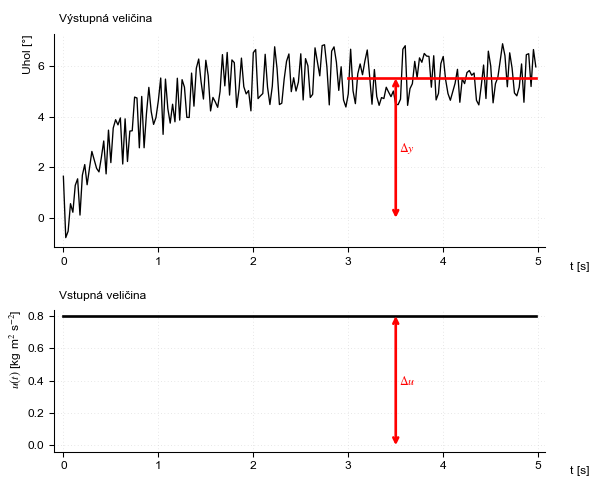

In [8]:
# Obrazok
figNameNum = 13
execfile('misc/figsc_11.py')

Statické zosilnenie systému je, samozrejme, možné zistiť aj pomocou prevodovej charakteristiky. V skutočnosti, všetko potrebné už máme k dispozícii.

Mimochodom, ak by sme neboli leniví, tak nájdeme dotyčnicu v pracovnom bode, a jej smernica (sklon) by mala byť statické zosilnenie. To by bol formálne korektný postup. My však leniví sme, preto:

Hľadáme sklon prevodovej charakteristiky v okolí pracovného bodu. Z praktického hľadiska, nech je sklon daný pracovným bodom a bodom ohraničujúcim okolie pracovného bodu zhora. Formálne $\text{sklon} = \frac{\Delta y}{\Delta u}$ kde $\Delta y = y_{PBh} - y_{PB}$ a $\Delta u = u_{PBh} - u_{PB}$. To je, samozrejme, to isté ako vyplynulo z využitia prechodovej charakteristiky vyššie. Tu však číselné hodnoty nie sú odčítané z prechodovej charakteristiky ale z modelu prevodovej charakteristiky. Konkrétne čísla sú:

In [9]:
PB1_sklon = (y_PB1_h - y_PB1) / ( u_PB1_okol )
print u'PB1_sklon = {:6.2f}'.format(PB1_sklon) + u'  [°/(kg m^2 s^-2)]'

PB1_sklon =   5.65  [°/(kg m^2 s^-2)]


Odchýlka od statického zosilnenia určeného z prechodovej charakteristiky je: (tá je samozrejme daná aj tým, že používame model prevodovej charakteristiky, keďže konkrétne potrebné hodnoty v rámci nameranej prevodovej charakteristiky nie sú dostupné)

In [10]:
PB1_sklon_odchylka = PB1_sklon - K
print u'PB1_sklon_odchylka = {:6.2f}'.format(PB1_sklon_odchylka) + u'  [°/(kg m^2 s^-2)]'
print u'PB1_sklon_odchylka = {:6.2f}'.format((np.abs(PB1_sklon_odchylka)/K)*100.0) + u'  [%]'

PB1_sklon_odchylka =  -1.25  [°/(kg m^2 s^-2)]
PB1_sklon_odchylka =  18.10  [%]


## Časová konštanta $T$ pre lineárny dynamický systém 1. rádu

Ďalej je možné nájsť model, ktorý má vystihovať dynamiku (dynamické vlastnosti) reálneho systému. Modelom nech je lineárny dynamický systém.

Kvalifikovaný odhad založený na grafickom znázornení predmetnej prechodovej charakteristiky vedie k možnosti, že modelom systému môže byť dynamický systém 1. rádu. Tento je možné zapísať v tvare prenosovej funkcie

$$
G(s) = \frac{y(s)}{u(s)} = \frac{K}{Ts+1}
$$

kde $K$ je možné interpretovať ako statické zosilnenie systému a $T$ je časová konštanta.

Časovú konštatnu je možné nájsť na základe prechodovej charakteristiky. Je to čas od začiatku prechodovej charakteristiky (od času jednotkového skoku), v ktorom výstupná veličina dosiahla približne 63% zo svojej ustálenej hodnoty.

Prečo práve 63%? Odpoveď sa ponecháva na čitateľa.

100% z ustálenej hodnoty na nasledujúcom obrázku je samozrejme hodnota $\Delta y$. Potom 63% je hodnota

In [11]:
Delta_y63 = Delta_y * 0.63
print u'Delta_y63 = {:6.2f}'.format(Delta_y63) + u'  [°]'

Delta_y63 =   3.48  [°]


Hodnotu $T$ teraz možno hľadať „od oka“, doslova pomocou grafu PCH, prípadne „od oka“, ale trošku inak - napr: Nájdime hodnoty výstupnej veličiny, ktoré sú v pásme (volajme ho „od oka“) $\pm ? \%$ v okolí hodnoty `Delta_y63`. Presnejšie, nádime časy tých vzoriek, ktoré sú v tom pásme:

In [12]:
temp_pct = 0.1
temp_Mask = np.logical_and( (posunutaPCH_y >= (Delta_y63-(Delta_y63*temp_pct))), (posunutaPCH_y <= (Delta_y63+(Delta_y63*temp_pct))))
print posunutaPCH_t[temp_Mask]

[ 0.475  0.525  0.575  0.7    0.725  0.95   1.05   1.125  1.175]


Priemer z nájdených časov je

In [13]:
T = np.mean(posunutaPCH_t[temp_Mask])
print u'T = {:6.2f}'.format(T) + u'  [s]'

T =   0.81  [s]


...a táto hodnota môže byť celkom dobre „od oka“ odčítaná časová konštanta. Nakreslime všetko uvedené do obrázka:

<IPython.core.display.Javascript object>


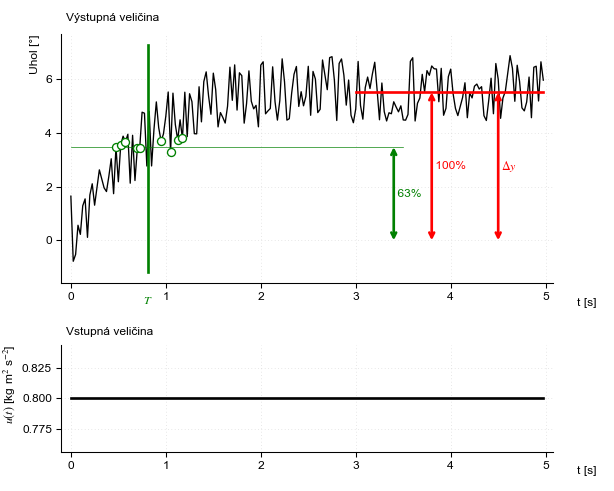

In [14]:
# Obrazok
figNameNum = figNameNum + 1
execfile('misc/figsc_12.py')

## Verifikácia identifikovaného dynamického modelu

V predchádzajúcom boli na základe prechodovej charakteristiky určené parametre lineárneho dynamického systému, ktorý má byť modelom skutočného systému. Tento model je možné vyjadriť v tvare prenosovej funkcie

$$
\frac{y(s)}{u(s)} = \frac{K}{Ts+1}
$$

Pre verifikáciu modelu je možné využiť grafické porovnanie prechodovej charakteristiky modelu a skuročnej prechodovej charakteristiky.

Pre získanie PCH modelu využime numerickú simuláciu. Daná prenosová funkcia zodpovedá diferenciálnej rovnici v tvare

$$
\begin{align}
    T \dot y(t) + y(t) &= K u(t) \\
    T \dot y(t) &= - y(t) + K u(t) \\
    \dot y(t) &= - \frac{1}{T} y(t) + \frac{K}{T} u(t)
\end{align}
$$

Rovnicu je možné zapísať v tvare funkcie použiteľnej pre ODE solver:

In [15]:
def fcn_ss1r(x, t, u):

    dotx = -(1.0/T) * x + (K/T) * u

    return dotx

Vstupný signál zvoľme rovnaký ako je veľkosť $\Delta u$ (je to premenná `u_PB1_okol`). Tak zabezpečíme zodpovedajúcu veľkosť jednotkového skoku, ktorý je použitý v numerickej simulácii pre získanie PCH.

Časový vektor, pre ktorý hľadáme numerické riešenie:

In [16]:
timeVect = np.arange(0, 5.0, 0.1)

Zavolajme ODE solver:

In [17]:
x = odeint(fcn_ss1r,
           [0],   # začiatočné podmienky
           timeVect,
           args=(u_PB1_okol,),
           )

Do spoločného obrázka nakreslime nameranú PCH a PCH modelu systému.

<IPython.core.display.Javascript object>


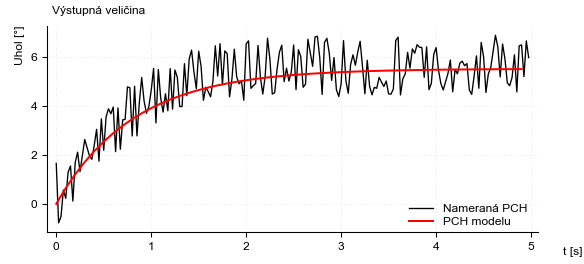

In [18]:
# Obrazok
figNameNum = figNameNum + 1
execfile('misc/figsc_13.py')

Týmto (aspoň pre naše potreby) možno model považovať za verifikovaný - znamená to, že daný model je schopný vystihnúť vlastnosti skutočného systému a že je možné na základe dostupných informácií (prechodová charakteristika) nájsť parametre modelu.